<a href="https://colab.research.google.com/github/AnirudhDesai777/EEG_Emotion_Classification/blob/main/Copy_of_psd_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install git+https://github.com/forrestbao/pyeeg.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/forrestbao/pyeeg.git to /tmp/pip-req-build-299lsms6
  Running command git clone -q https://github.com/forrestbao/pyeeg.git /tmp/pip-req-build-299lsms6


In [ ]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 11.7,8.27

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pickle as pickle
import pandas as pd
import pyeeg as pe


from sklearn import svm
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


In [ ]:
channel = [2,3,4,6,7,11,15,17,20,24,25,27,28,29]
 #14 Channels chosen to fit Emotiv Epoch+
band = [4,8,12,16,25,45] #5 bands
window_size = 512 #Averaging band power of 2 sec
step_size = 64 #Each 0.5 sec update once
sample_rate = 128 #Sampling rate of 128 Hz

In [ ]:
def FFT_Processing (sub, channel, band, window_size, step_size, sample_rate):
    '''
    arguments:  string subject
                list channel indice
                list band
                int window size for FFT
                int step size for FFT
                int sample rate for FFT
    return:     void
    '''
    meta = []
    with open('/content/drive/My Drive/data_preprocessed_python/s' + sub + '.dat', 'rb') as file:

        subject = pickle.load(file, encoding='latin1') #resolve the python 2 data problem by encoding : latin1

        for i in range (0,40):
            # loop over 0-39 trails
            data = subject["data"][i]
            labels = subject["labels"][i]
            start = 384;

            while start + window_size < data.shape[1]:
                meta_array = []
                meta_data = [] #meta vector for analysis
                for j in channel:
                    X = data[j][start : start + window_size] #Slice raw data over 2 sec, at interval of 0.125 sec
                    Y = pe.bin_power(X, band, sample_rate) #FFT over 2 sec of channel j, in seq of theta, alpha, low beta, high beta, gamma
                    
                    meta_data = meta_data + list(Y[0])

                meta_array.append(np.array(meta_data))
                meta_array.append(labels)

                meta.append(np.array(meta_array))    
                start = start + step_size
                
        meta = np.array(meta)
        np.save('/content/drive/My Drive/data_preprocessed_python/out/s' + sub, meta, allow_pickle=True, fix_imports=True)



In [ ]:
# subjectList = ['01','05','07','14','15','17','19','28']
subjectList = []
for i in range(1,33):
  if i <10:
    s = '0'+str(i)
  else:
    s = str(i)
  subjectList.append(s)
print(subjectList)

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32']


In [ ]:
# subjectList = ['01']
for subjects in subjectList:
    print(subjects)
    FFT_Processing (subjects, channel, band, window_size, step_size, sample_rate)

01


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


02
03
04
05
06
07
08
09
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32


In [ ]:
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
print(C_range, gamma_range)

[1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04 1.e+05 1.e+06 1.e+07
 1.e+08 1.e+09 1.e+10] [1.e-09 1.e-08 1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00
 1.e+01 1.e+02 1.e+03]


In [ ]:
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
n = [5,10,20,40,80,160]
e = [100,200,300,400,500]
res = []
h_acc4, h_n = 0,0
h_acc2, h_e = 0,0
h_acc3, h_c, h_gamma = 0,0,0
for i in range(29,33):
  h_acc4, h_n = 0,0
  h_acc2, h_e = 0,0
  h_acc3, h_c, h_gamma = 0,0,0
  
  if i <10:
    s = '0'+str(i)
  else:
    s = str(i)
  
  data, label = load_data([s])
  # print(data.shape, label.shape)

  df_emo = one_hot_encoding(label)
  # print(df_emo.loc[:,0].unique())
  r=[s,data.shape,label.shape,len(df_emo.iloc[:,0].unique())]
  x_train, x_test, y_train, y_test = data_normalization_splitting(data, df_emo, scaling_type='MM')

  clf1, acc1 = rbf_svm(x_train, x_test, y_train, y_test)
  acc1 *= 100
  # print(acc1)
  r.append(acc1)
  
  for n_estimators in e:
    
    clf2, acc2 = rf(x_train, x_test, y_train, y_test, n_estimators=n_estimators)
    acc2 *= 100
    # print(acc2, h_acc2)
    if acc2 >= h_acc2:
        h_acc2 = acc2
        h_e = n_estimators
    # print(acc2, h_acc2)
    
    # print(h_e,h_acc2)
  r.append([h_e, h_acc2])
  
  for c in C_range:
    for gamma in gamma_range:
      
      clf3, acc3 = rbf_svm_c_gamma(x_train, x_test, y_train, y_test,c=c, gamma=gamma)
      acc3 *= 100
      # print(acc3, h_acc3)
      if acc3 >= h_acc3:
        h_acc3 = acc3
        h_g = gamma
        h_c = c
      # print(acc3, h_acc3)
  r.append([h_c,h_gamma,h_acc3])
  
  for n_neighbours in n:
    
    clf4, acc4 = knn(x_train, x_test, y_train, y_test, n_neighbours=n_neighbours)
    acc4*= 100
    # print(acc4, h_acc4)
    if acc4 >= h_acc4:
      h_acc4 = acc4
      h_n = n_neighbours
    # print(acc4, h_acc4)
  r.append([h_n, h_acc4])

  print(r)
  res.append(r)

NameError: ignored

In [ ]:
res

[['29',
  (1120, 70),
  (1120, 4),
  7,
  48.660714285714285,
  [100, 66.51785714285714],
  [10000000000.0, 0, 65.625],
  [5, 48.214285714285715]],
 ['30',
  (1120, 70),
  (1120, 4),
  7,
  45.535714285714285,
  [300, 54.46428571428571],
  [10000000000.0, 0, 67.41071428571429],
  [5, 53.125]],
 ['31',
  (1120, 70),
  (1120, 4),
  6,
  50.0,
  [500, 62.94642857142857],
  [1000.0, 0, 67.41071428571429],
  [5, 49.55357142857143]],
 ['32',
  (1120, 70),
  (1120, 4),
  8,
  64.73214285714286,
  [500, 74.55357142857143],
  [10000000000.0, 0, 81.69642857142857],
  [5, 64.73214285714286]]]

In [ ]:
df1 = pd.DataFrame(res,columns=['Subject','Shape of Data','Shape of Label','Len of Emotion','RBF SVM','RF','RBF SVM WITH C AND GAMMA','KNN'])

In [ ]:
df.to_csv('/content/drive/My Drive/data_preprocessed_python/Results.csv')

In [ ]:
frames = [df, df1]
df = pd.concat(frames)

In [ ]:
data, label = load_data(subjectList)
df_emo = one_hot_encoding(label)
x_train, x_test, y_train, y_test = data_normalization_splitting(data, df_emo, scaling_type='SS')
clf1, acc1 = rbf_svm(x_train, x_test, y_train, y_test)
print(acc1*100)
clf2, acc2 = rf(x_train, x_test, y_train, y_test, n_estimators=500)
print(acc2*100)
clf3, acc3 = rbf_svm_c_gamma(x_train, x_test, y_train, y_test,c=10000000000, gamma='auto')
print(acc3*100)
clf4, acc4 = knn(x_train, x_test, y_train, y_test, n_neighbours=3)
print(acc4*100)


(57344, 70)
(57344,)
(14336, 70)
(14336,)


In [ ]:
for i in range(1,33):
  if i <10:
    i='0'+str(i)
  else:
    i = str(i)
  subjectList = [i]
  data, label = load_data(subjectList)
  df_emo = one_hot_encoding(label)
  x = data
  y = df_emo.loc[:,0]
  scaler = StandardScaler()
  x = scaler.fit_transform(x)
  pred1 = clf1.predict(x) 
  acc1 = metrics.accuracy_score(y, pred1)
  # print(i,acc1)
  pred2 = clf2.predict(x) 
  acc2 = metrics.accuracy_score(y, pred2)
  pred3 = clf3.predict(x) 
  acc3 = metrics.accuracy_score(y, pred3)
  pred4 = clf4.predict(x) 
  acc4 = metrics.accuracy_score(y, pred4)
  print(i,acc1*100, acc2*100, acc3*100, acc4*100)

01 14.910714285714285 10.625 20.44642857142857 10.267857142857142
02 11.875 13.4375 10.803571428571429 10.491071428571429
03 14.955357142857142 10.357142857142858 13.973214285714286 11.473214285714285
04 23.526785714285715 20.0 16.69642857142857 17.008928571428573
05 22.544642857142858 21.071428571428573 24.151785714285715 18.348214285714285
06 12.544642857142858 19.642857142857142 14.196428571428571 9.0625
07 23.883928571428573 20.84821428571429 23.482142857142858 16.428571428571427
08 21.294642857142858 27.098214285714285 16.25 15.714285714285714
09 20.133928571428573 25.80357142857143 16.5625 13.660714285714285
10 15.491071428571429 23.080357142857146 13.750000000000002 15.401785714285715


KeyboardInterrupt: ignored

In [ ]:
n = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
x=[]
y=[]
for n_neighbours in n:
  clf4, acc4 = knn(x_train, x_test, y_train, y_test, n_neighbours=n_neighbours)
  print(n_neighbours,acc4*100)
  x.append(n_neighbours)
  y.append(acc4*100)

1 81.02678571428571
2 72.8515625
3 72.76785714285714
4 69.83816964285714
5 68.77790178571429
6 67.63392857142857
7 65.93191964285714
8 63.58816964285714
9 61.96986607142857
10 61.16071428571429
11 60.9375
12 59.43080357142857
13 59.34709821428571
14 59.20758928571429
15 58.34263392857143


In [ ]:
(14848, 70)
(14848,)
(3712, 70)
(3712,)
38.685344827586206
57.327586206896555
53.98706896551724
46.470905172413794


41.85267857142857
78.73883928571429
78.40401785714286
68.77790178571429

46.470905172413794

In [ ]:
def load_data(subjectList):
  data= []
  label = []
  for subjects in subjectList:
    

      with open('/content/drive/My Drive/data_preprocessed_python/out/s' + subjects + '.npy', 'rb') as file:
          sub = np.load(file,allow_pickle=True)
          for i in range (0,sub.shape[0]):
            data.append(sub[i][0])
            label.append(sub[i][1])
  data=pd.DataFrame(data=data)


  label=pd.DataFrame(data=label)
  return data, label

In [ ]:
data

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
0,2502.653831,2530.152492,2548.195214,4431.769472,2902.560416,2691.958852,2671.844196,2283.133521,3631.513688,3114.388372,...,2910.670701,2788.197275,2752.632529,3940.817731,3079.924818,2031.920433,2890.894072,1825.151058,3102.260247,3518.313119
1,3597.453369,2526.681572,2952.572930,4331.456845,2761.386842,3887.906296,3064.777367,2563.715691,3534.802514,3531.432024,...,4902.261653,3526.883885,3156.156757,3905.096001,3033.334037,1944.374036,3010.082617,2214.749215,2757.789222,3576.302781
2,3614.150205,2106.889831,2159.814743,3604.130198,2831.229905,4010.293803,2543.676481,2130.009818,3390.128588,3385.126632,...,5034.253875,3231.210466,3013.937543,3757.153145,2835.520556,1875.782485,2765.241608,2424.183281,2828.661434,3455.856308
3,3345.756258,2057.208783,1941.020266,3539.967757,2812.241681,3957.754659,2691.342448,2068.686044,3418.240433,3324.208098,...,5234.255222,3032.991009,2878.939431,3210.568130,2775.739623,1783.264297,2737.765931,2463.047994,2393.612697,3545.709123
4,4201.421807,2313.500592,2700.339063,3426.303265,3060.129319,4664.086284,2877.552469,2544.845027,2873.101370,3586.578232,...,6041.003760,3720.313877,3180.554949,2670.540940,3204.088296,2082.506590,2407.404370,2571.794654,2468.023987,3518.744728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22395,14828.910678,6812.520563,6215.651454,11373.314728,36719.165873,13015.141473,6624.454754,7913.434861,15431.880315,49969.713885,...,9884.554867,4728.804890,3804.842751,7582.467056,22477.162466,6111.345297,4069.467510,3667.334821,8488.161638,24336.902549
22396,18589.626085,8752.812298,6831.208138,14098.436544,45216.472567,19353.939633,11421.281000,8860.951098,19242.581278,60782.096715,...,11758.635032,5224.518894,4224.855784,9261.720980,28203.106783,9110.777487,5564.610533,3865.556684,10910.069774,29759.649358
22397,20063.898134,9904.570193,8777.701844,17396.449225,49313.733471,22196.183564,13808.371973,11595.368892,24011.367184,67275.642764,...,12725.075897,6107.221385,5432.475002,11438.712859,31507.893896,10502.314377,7302.477340,5651.599896,12940.900170,32475.935983
22398,21315.704525,11115.850741,9444.538120,17746.527696,52978.444224,25015.259520,16260.888307,12714.964223,24363.966016,70819.402302,...,13287.950135,7439.725630,5461.852999,11325.128211,33363.151171,11911.634787,8434.734838,6331.109977,12733.816158,34490.289261


In [ ]:
label

,0,1,2,3
0,7.71,7.60,6.90,7.83
1,7.71,7.60,6.90,7.83
2,7.71,7.60,6.90,7.83
3,7.71,7.60,6.90,7.83
4,7.71,7.60,6.90,7.83
...,...,...,...,...
22395,5.78,6.15,7.04,6.44
22396,5.78,6.15,7.04,6.44
22397,5.78,6.15,7.04,6.44
22398,5.78,6.15,7.04,6.44


In [ ]:
data = data.sample(frac=0.16)
label = label.sample(frac=0.16)

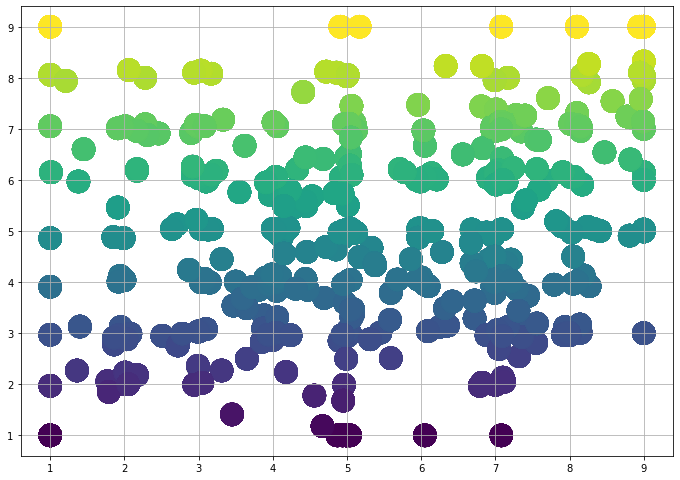

In [ ]:
import matplotlib.pyplot as plt
valence = label.loc[:,0]
arousal = label.loc[:,1]
plt.scatter(valence, arousal,c=arousal, s= 500)
plt.grid()
plt.show()

In [ ]:
def one_hot_encoding(df):
  emotions = []
  for i in range(len(df)):
    emotion = -1
    e = ''
    val = int(df.iloc[i,0])
    aro = int(df.iloc[i,1])
    if val in range(1,4) and aro in range(1,4):
      emotion = 0 #'depressed'
    elif val in range(4,7) and aro in range(1,4):
      emotion,e = 1, 'calm'
    elif val in range(7,10) and aro in range(1,4):
      emotion,e = 2, 'relaxed'
    elif val in range(1,4) and aro in range(4,7):
      emotion = 3 #'miserable'
    elif val in range(4,7) and aro in range(4,7):
      emotion = 4 #'neutral'
    elif val in range(7,10) and aro in range(4,7):
      emotion = 5 #'pleased'
    elif val in range(1,4) and aro in range(7,10):
      emotion = 6 #'distressed'
    elif val in range(4,7) and aro in range(7,10):
      emotion = 7 #'excited'
    elif val in range(7,10) and aro in range(7,10):
      emotion = 8 #'happy'
    # print(val,aro,emotion)
    emotions.append(emotion)
  df_emo = pd.DataFrame(emotions)
  return df_emo


In [ ]:
x = 4.6
if x in range(4,6):
  print('true')

In [ ]:
df_emo = one_hot_encoding(label)

In [ ]:
len(df_emo.iloc[:,0].unique())

9

In [ ]:
df_emo.tail()

,0
6955,4
6956,4
6957,4
6958,4
6959,4


In [ ]:
for i in range(-10,-1):
  val = label.iloc[i,0]
  aro = label.iloc[i,1]
  print(val, aro)
  if val >=5 and aro >=5:
    emotion = 
  elif val >=5 and aro <5:
    emotion = 'anxious'
  elif val <5 and aro <5:
    emotion = 'sad'
  else:
    emotion = 'calm'
  print(emotion)

3.99 7.17
calm
3.99 7.17
calm
3.99 7.17
calm
3.99 7.17
calm
3.99 7.17
calm
3.99 7.17
calm
3.99 7.17
calm
3.99 7.17
calm
3.99 7.17
calm


In [ ]:
def data_normalization_splitting(data, emo, scaling_type='SS'):
  from sklearn.preprocessing import MinMaxScaler
  if scaling_type == 'SS':
    x = data
    scaler = StandardScaler()
    x = scaler.fit_transform(x)
  elif scaling_type == 'MM':
    x = data
    scaler = MinMaxScaler(feature_range=(0.1,1))
    x = scaler.fit_transform(x)
  x_train, x_test, y_train, y_test = train_test_split(x,emo.loc[:,0] ,test_size = 0.2, random_state = 4)
  print(x_train.shape)
  print(y_train.shape)
  print(x_test.shape)
  print(y_test.shape)
  return x_train, x_test, y_train, y_test

In [ ]:
from sklearn.preprocessing import StandardScaler
x = data
scaler = StandardScaler()
x = scaler.fit_transform(x)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
x = data
scaler = MinMaxScaler(feature_range=(0.1,1))
x = scaler.fit_transform(x)

In [ ]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(df_emo.iloc[:,0])

In [ ]:
y_val = label.loc[:,0]
y_aro = label.loc[:,1]

In [ ]:
y_val = y_val.astype('int')
y_aro = y_aro.astype('int')

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,df_emo.loc[:,0] ,test_size = 0.2, random_state = 4)

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(17920, 70)
(17920,)
(4480, 70)
(4480,)


In [ ]:
len(y_val.unique())

9

In [ ]:
def rbf_svm(x_train, x_test,y_train, y_test):
  
  c = svm.SVC(kernel='rbf')
  c.fit(x_train,y_train)
  
  pred = c.predict(x_test) 
  acc = metrics.accuracy_score(y_test, pred)
  # print("ACCURACY OF THE MODEL: ", acc)

  return c, acc

In [ ]:
pred = c.predict(x_test)
from sklearn import metrics 
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, pred))

ACCURACY OF THE MODEL:  0.7991071428571429


In [ ]:
# linear = svm.SVC(kernel='linear', C=1, decision_function_shape='ovo').fit(x_train, y_train)
# rbf = svm.SVC(kernel='rbf', gamma=1, C=1, decision_function_shape='ovo').fit(x_train, y_train)
# poly = svm.SVC(kernel='poly', degree=3, C=1, decision_function_shape='ovo').fit(x_train, y_train)
# sig = svm.SVC(kernel='sigmoid', C=1, decision_function_shape='ovo').fit(x_train, y_train)

In [ ]:
linear_pred = linear.predict(x_test)
poly_pred = poly.predict(x_test)
rbf_pred = rbf.predict(x_test)
sig_pred = sig.predict(x_test)

In [ ]:
accuracy_lin = linear.score(x_test, y_test)
accuracy_poly = poly.score(x_test, y_test)
accuracy_rbf = rbf.score(x_test, y_test)
accuracy_sig = sig.score(x_test, y_test)
print("Accuracy Linear Kernel:", accuracy_lin)
print("Accuracy Polynomial Kernel:", accuracy_poly)
print("Accuracy Radial Basis Kernel:", accuracy_rbf)
print("Accuracy Sigmoid Kernel:", accuracy_sig)

Accuracy Linear Kernel: 0.48815370035323513
Accuracy Polynomial Kernel: 0.5276126475402774
Accuracy Radial Basis Kernel: 0.6881192383906264
Accuracy Sigmoid Kernel: 0.3645214094942707


In [ ]:
cm_lin = confusion_matrix(y_test, linear_pred)
cm_poly = confusion_matrix(y_test, poly_pred)
cm_rbf = confusion_matrix(y_test, rbf_pred)
cm_sig = confusion_matrix(y_test, sig_pred)
print(cm_lin)
print(cm_poly)
print(cm_rbf)
print(cm_sig)

NameError: ignored

In [ ]:
def rf(x_train, x_test, y_train, y_test, n_estimators=100):

  clf = RandomForestClassifier(n_estimators = n_estimators) 
  clf.fit(x_train, y_train)
  pred = clf.predict(x_test)
  acc = metrics.accuracy_score(y_test, pred)
  # print("ACCURACY OF THE MODEL: ", acc)
  # print(n_estimators)
  return clf, acc

In [ ]:
pred = clf.predict(x_test)

In [ ]:
from sklearn import metrics 
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, pred))

ACCURACY OF THE MODEL:  0.7928571428571428


In [ ]:
from sklearn.metrics  import confusion_matrix
confusion_matrix(y_test, pred)

array([[2540,  120,   35,   15,  179,    9,   31,    8,  197],
       [ 136, 2356,   58,   27,  296,   18,   49,    8,  136],
       [  17,  108, 1366,   22,  154,   22,   56,    4,  100],
       [ 153,   55,   11,  994,  149,   14,   25,    5,   41],
       [ 133,  164,   62,   24, 2715,   17,   59,    8,  101],
       [  99,  111,   65,   19,  278, 1002,   21,    4,  157],
       [  11,    4,    7,   27,   85,    7, 1086,    7,  108],
       [  16,   32,   14,   17,  139,    9,   84,  547,   47],
       [ 117,   36,    5,   10,  109,   19,   75,    8, 2165]])

In [ ]:
from sklearn.metrics import classification_report
classification_report(y_test, pred)

'              precision    recall  f1-score   support\n\n           0       0.79      0.81      0.80      3134\n           1       0.79      0.76      0.78      3084\n           2       0.84      0.74      0.79      1849\n           3       0.86      0.69      0.76      1447\n           4       0.66      0.83      0.74      3283\n           5       0.90      0.57      0.70      1756\n           6       0.73      0.81      0.77      1342\n           7       0.91      0.60      0.73       905\n           8       0.71      0.85      0.77      2544\n\n    accuracy                           0.76     19344\n   macro avg       0.80      0.74      0.76     19344\nweighted avg       0.78      0.76      0.76     19344\n'

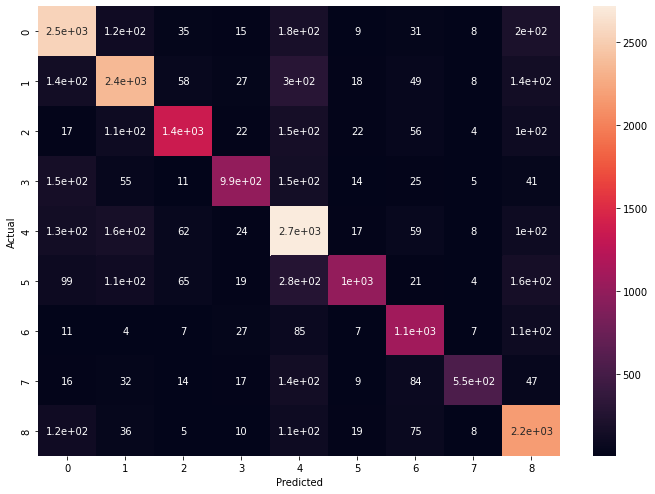

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt
data = {'y_Actual':    y_test,
        'y_Predicted': pred
        }
df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True)
plt.show()

In [ ]:
from sklearn import metrics 
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, pred))

ACCURACY OF THE MODEL:  0.7927522746071133


In [ ]:
import sklearn
print(sklearn.metrics.precision_recall_fscore_support(y_test, pred))

(array([0.78833023, 0.78901541, 0.84165126, 0.86060606, 0.66154971,
       0.89704566, 0.730821  , 0.91318865, 0.7093709 ]), array([0.81046586, 0.76394293, 0.73877772, 0.68693849, 0.82698751,
       0.57061503, 0.80923994, 0.60441989, 0.85102201]), array([0.79924481, 0.77627677, 0.78686636, 0.76402767, 0.73507513,
       0.69752872, 0.76803395, 0.72739362, 0.77376698]), array([3134, 3084, 1849, 1447, 3283, 1756, 1342,  905, 2544]))


In [ ]:
def rbf_svm_c_gamma(x_train, x_test, y_train, y_test, c=10, gamma=0.1):
  
  clf = svm.SVC(kernel='rbf',C=c,gamma=gamma)
  clf.fit(x_train,y_train)

  pred = clf.predict(x_test)
  acc = metrics.accuracy_score(y_test, pred)
  # print("ACCURACY OF THE MODEL: ", acc)
  # print(c, gamma)
  return clf, acc

In [ ]:
def knn(x_train, x_test, y_train, y_test,n_neighbours):
  knn = KNeighborsClassifier(n_neighbors=n_neighbours)
  knn.fit(x_train, y_train)
  pred=knn.predict(x_test)
  acc = metrics.accuracy_score(y_test, pred)
  # print("ACCURACY OF THE MODEL: ", acc)
  # print(n_neighbours)
  return knn, acc

In [ ]:
#RBF SVM
from sklearn import svm
c = svm.SVC(kernel='rbf',C=10,gamma=0.1)
c.fit(x_train,y_train)

NameError: ignored

In [ ]:
pred = c.predict(x_test)

In [ ]:
from sklearn import metrics 
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, pred))

ACCURACY OF THE MODEL:  0.34464285714285714


In [ ]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=10,
                         learning_rate=0.01)
model = clf.fit(x_train, y_train)
y_pred = model.predict(x_test)
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))

ACCURACY OF THE MODEL:  0.27232142857142855


In [ ]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(x_train, y_train)

GaussianNB()

In [ ]:
from sklearn.metrics import confusion_matrix,accuracy_score
cm = confusion_matrix(y_test, y_pred)
ac = accuracy_score(y_test,y_pred)

In [ ]:
ac

0.27232142857142855

In [ ]:
import numpy as np
from sklearn.preprocessing import normalize
import pickle as pickle
import matplotlib.pyplot as plt
import pandas as pd
import pyeeg as pe
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM,BatchNormalization,Activation
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM,BatchNormalization,Activation
import tensorflow

In [ ]:
res = []

In [ ]:
for i in range(1,33):
  if i <10:
    i = '0'+str(i)
  else:
    i = str(i)
  subjectList = [i]
  print(subjectList)
  data, label = load_data(subjectList)
  df_emo = one_hot_encoding(label)
  # n_e = len(df_emo.loc[:,0].unique())
  print(n_e)
  x = data
  y = df_emo.loc[:,0]
  scaler = StandardScaler()
  x = scaler.fit_transform(x)
  x = np.reshape(x, (x.shape[0],1,x.shape[1]))
  y = to_categorical(y)
  n_e = y.shape[-1]
  x_train1, x_test1, y_train1, y_test1 = train_test_split(x, y, test_size = 0.2, random_state = 4)
  model1 = model(n_e)
  history1 = model1.fit(x_train1, y_train1, verbose=0,epochs = 100, batch_size=100,validation_data= (x_test1, y_test1))
  r = [i,history1.history['accuracy'][-1],history1.history['val_accuracy'][-1]]
  print(r)
  res.append(r)

['01']
7
['01', 0.984375, 0.9854910969734192]
['02']
9
['02', 0.9321986436843872, 0.9375]
['03']
9
['03', 0.9587053656578064, 0.9654017686843872]
['04']
8
['04', 0.8962053656578064, 0.8939732313156128]
['05']
9
['05', 0.88671875, 0.8649553656578064]
['06']
9
['06', 0.9665178656578064, 0.9832589030265808]
['07']
9
['07', 0.9799107313156128, 0.9921875]
['08']
9
['08', 0.9517298936843872, 0.9665178656578064]
['09']
9
['09', 0.9701451063156128, 0.9587053656578064]
['10']
9
['10', 0.9204798936843872, 0.9151785969734192]
['11']
9
['11', 0.9026227593421936, 0.9386160969734192]
['12']
7
['12', 0.9450334906578064, 0.9352678656578064]
['13']
9
['13', 0.9282923936843872, 0.9017857313156128]
['14']
9
['14', 0.9291294813156128, 0.9285714030265808]
['15']
9
['15', 0.9737723469734192, 0.9799107313156128]
['16']
9
['16', 0.9771205186843872, 0.9888392686843872]
['17']
8
['17', 0.9467076063156128, 0.9319196343421936]
['18']
9
['18', 0.9659598469734192, 0.96875]
['19']
8
['19', 0.962890625, 0.9609375]
['

In [ ]:
df = pd.DataFrame(res,columns=['Subject','Accuracy','Val Accuracy'])

In [ ]:
df

,Subject,Accuracy,Val Accuracy
0,01,0.984375,0.985491
1,02,0.932199,0.937500
2,03,0.958705,0.965402
3,04,0.896205,0.893973
4,05,0.886719,0.864955
5,06,0.966518,0.983259
6,07,0.979911,0.992188
7,08,0.951730,0.966518
8,09,0.970145,0.958705
9,10,0.920480,0.915179


In [ ]:
df.to_csv('/content/drive/My Drive/data_preprocessed_python/psd_lstm_Results.csv')

In [ ]:
subjectList = ['01']
data, label = load_data(subjectList)
df_emo = one_hot_encoding(label)
x = data
y = df_emo.loc[:,0]
scaler = StandardScaler()
x = scaler.fit_transform(x)
x = np.reshape(x, (x.shape[0],1,x.shape[1]))
y = to_categorical(y)
x_train1, x_test1, y_train1, y_test1 = train_test_split(x, y, test_size = 0.2, random_state = 4)

In [ ]:
x = np.reshape(x, (x.shape[0],1,x.shape[1]))

In [ ]:
y = df_emo.loc[:,0]
y = to_categorical(y)

In [ ]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(x, y, test_size = 0.2, random_state = 4)

In [ ]:
print(x_train1.shape)
print(y_train1.shape)
print(x_test1.shape)
print(y_test1.shape)

(3584, 1, 70)
(3584, 9)
(896, 1, 70)
(896, 9)


In [ ]:

model = Sequential()
model.add(LSTM(512, batch_input_shape = (None, None, x.shape[2]),return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.3))


model.add(LSTM(256,activation="relu",return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.5))


model.add(LSTM(128,activation="relu",return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(LSTM(64,activation="relu",return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.3))


model.add(LSTM(32,activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))


model.add(Dense(9))
model.add(Activation('softmax'))



rmsprop =tensorflow.keras.optimizers.RMSprop(lr=0.0005, rho=0.9, epsilon=1e-08)
model.compile(loss='mean_squared_error',
                  optimizer=rmsprop,
                  metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 512)         1193984   
                                                                 
 batch_normalization (BatchN  (None, None, 512)        2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, None, 512)         0         
                                                                 
 lstm_1 (LSTM)               (None, None, 256)         787456    
                                                                 
 batch_normalization_1 (Batc  (None, None, 256)        1024      
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, None, 256)         0

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


 batch_normalization_3 (Batc  (None, None, 64)         256       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, None, 64)          0         
                                                                 
 lstm_4 (LSTM)               (None, 32)                12416     
                                                                 
 batch_normalization_4 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 9)                 297       
                                                                 
 activation (Activation)     (None, 9)                 0         
          

In [ ]:
history = model.fit(x_train1, y_train1, epochs = 500, batch_size=150,validation_data= (x_test1, y_test1))

Epoch 1/500
516/516 [==============================] - 40s 50ms/step - loss: 0.0974 - accuracy: 0.2387 - val_loss: 0.0908 - val_accuracy: 0.2940
Epoch 2/500
516/516 [==============================] - 23s 44ms/step - loss: 0.0912 - accuracy: 0.2896 - val_loss: 0.0875 - val_accuracy: 0.3375
Epoch 3/500
516/516 [==============================] - 21s 41ms/step - loss: 0.0891 - accuracy: 0.3171 - val_loss: 0.0869 - val_accuracy: 0.3334
Epoch 4/500
516/516 [==============================] - 22s 43ms/step - loss: 0.0873 - accuracy: 0.3390 - val_loss: 0.0844 - val_accuracy: 0.3626
Epoch 5/500
516/516 [==============================] - 21s 41ms/step - loss: 0.0861 - accuracy: 0.3515 - val_loss: 0.0831 - val_accuracy: 0.3710
Epoch 6/500
516/516 [==============================] - 22s 43ms/step - loss: 0.0849 - accuracy: 0.3666 - val_loss: 0.0819 - val_accuracy: 0.3876
Epoch 7/500
516/516 [==============================] - 22s 42ms/step - loss: 0.0841 - accuracy: 0.3715 - val_loss: 0.0807 - val_ac

In [ ]:
def model(n_e):
  model1 = Sequential()
  model1.add(LSTM(512, batch_input_shape = (None, None, x.shape[2]),return_sequences=True))
  model1.add(BatchNormalization())
  model1.add(Dropout(0.3))


  model1.add(LSTM(256,activation="tanh",return_sequences=True))
  model1.add(BatchNormalization())
  model1.add(Dropout(0.5))


  model1.add(LSTM(128,activation="tanh",return_sequences=True))
  model1.add(BatchNormalization())
  model1.add(Dropout(0.3))

  model1.add(LSTM(64,activation="tanh",return_sequences=True))
  model1.add(BatchNormalization())
  model1.add(Dropout(0.3))


  model1.add(LSTM(32,activation="tanh"))
  model1.add(BatchNormalization())
  model1.add(Dropout(0.2))


  model1.add(Dense(n_e))
  model1.add(Activation('softmax'))



  rmsprop =tensorflow.keras.optimizers.RMSprop(learning_rate=0.0005)
  model1.compile(loss='mean_squared_error',
                    optimizer=rmsprop,
                    metrics=['accuracy'])
  # model1.summary()
  return(model1)

In [ ]:
subjectList = ['03']
data, label = load_data(subjectList)
df_emo = one_hot_encoding(label)
x = data
y = df_emo.loc[:,0]
print(df_emo.loc[:,0].unique())
scaler = StandardScaler()
x = scaler.fit_transform(x)
x = np.reshape(x, (x.shape[0],1,x.shape[1]))
y = to_categorical(y)
x_train1, x_test1, y_train1, y_test1 = train_test_split(x, y, test_size = 0.2, random_state = 4)
print(x_train1.shape)
print(y_train1.shape)
print(x_test1.shape)
print(y_test1.shape)

[4 5 2 1 0 7 3]
(3584, 1, 70)
(3584, 8)
(896, 1, 70)
(896, 8)


In [ ]:
y.shape[-1]

8

In [ ]:
model1 = Sequential()
model1.add(LSTM(512, batch_input_shape = (None, None, x.shape[2]),return_sequences=True))
model1.add(BatchNormalization())
model1.add(Dropout(0.3))


model1.add(LSTM(256,activation="tanh",return_sequences=True))
model1.add(BatchNormalization())
model1.add(Dropout(0.5))


model1.add(LSTM(128,activation="tanh",return_sequences=True))
model1.add(BatchNormalization())
model1.add(Dropout(0.3))

model1.add(LSTM(64,activation="tanh",return_sequences=True))
model1.add(BatchNormalization())
model1.add(Dropout(0.3))


model1.add(LSTM(32,activation="tanh"))
model1.add(BatchNormalization())
model1.add(Dropout(0.2))

# model1.add(keras.layers.Flatten())
model1.add(Dense(8))
model1.add(Activation('softmax'))



rmsprop =tensorflow.keras.optimizers.RMSprop(learning_rate=0.0005)
model1.compile(loss='mean_squared_error',
                  optimizer=rmsprop,
                  metrics=['accuracy'])
model1.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_75 (LSTM)              (None, None, 512)         1193984   
                                                                 
 batch_normalization_75 (Bat  (None, None, 512)        2048      
 chNormalization)                                                
                                                                 
 dropout_75 (Dropout)        (None, None, 512)         0         
                                                                 
 lstm_76 (LSTM)              (None, None, 256)         787456    
                                                                 
 batch_normalization_76 (Bat  (None, None, 256)        1024      
 chNormalization)                                                
                                                                 
 dropout_76 (Dropout)        (None, None, 256)       

In [ ]:
history1 = model1.fit(x_train1, y_train1, epochs = 100, batch_size=100,validation_data= (x_test1, y_test1))

Epoch 1/100
36/36 [==============================] - 11s 74ms/step - loss: 0.1096 - accuracy: 0.1775 - val_loss: 0.0980 - val_accuracy: 0.2667
Epoch 2/100
36/36 [==============================] - 1s 17ms/step - loss: 0.1001 - accuracy: 0.2528 - val_loss: 0.0975 - val_accuracy: 0.2667
Epoch 3/100
36/36 [==============================] - 1s 17ms/step - loss: 0.0955 - accuracy: 0.3052 - val_loss: 0.0972 - val_accuracy: 0.2690
Epoch 4/100
36/36 [==============================] - 1s 17ms/step - loss: 0.0921 - accuracy: 0.3373 - val_loss: 0.0966 - val_accuracy: 0.3270
Epoch 5/100
36/36 [==============================] - 1s 17ms/step - loss: 0.0889 - accuracy: 0.3733 - val_loss: 0.0957 - val_accuracy: 0.3438
Epoch 6/100
36/36 [==============================] - 1s 17ms/step - loss: 0.0858 - accuracy: 0.3948 - val_loss: 0.0938 - val_accuracy: 0.3917
Epoch 7/100
36/36 [==============================] - 1s 17ms/step - loss: 0.0818 - accuracy: 0.4322 - val_loss: 0.0905 - val_accuracy: 0.4152
Epoch

In [ ]:
r= [history1.history['accuracy'][-1],history1.history['val_accuracy'][-1]]
print(r)
res.append(r)
print(res)


[0.9430803656578064, 0.9285714030265808]
[[0.9835379719734192, 0.9832589030265808], [0.9430803656578064, 0.9285714030265808]]


In [ ]:
res = []

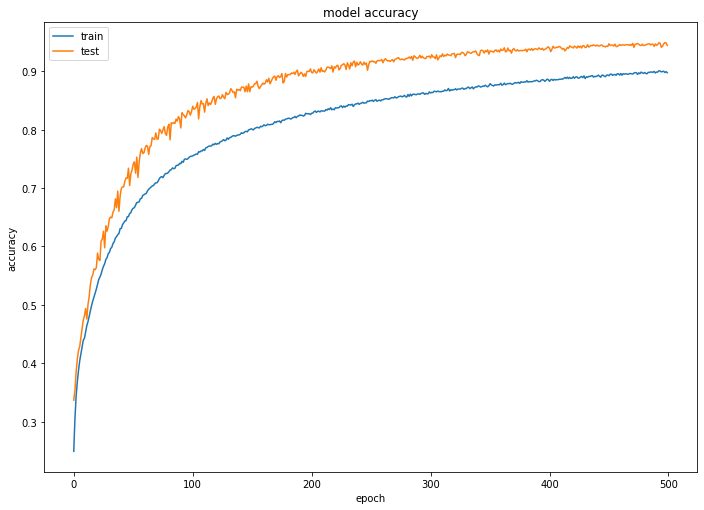

In [ ]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

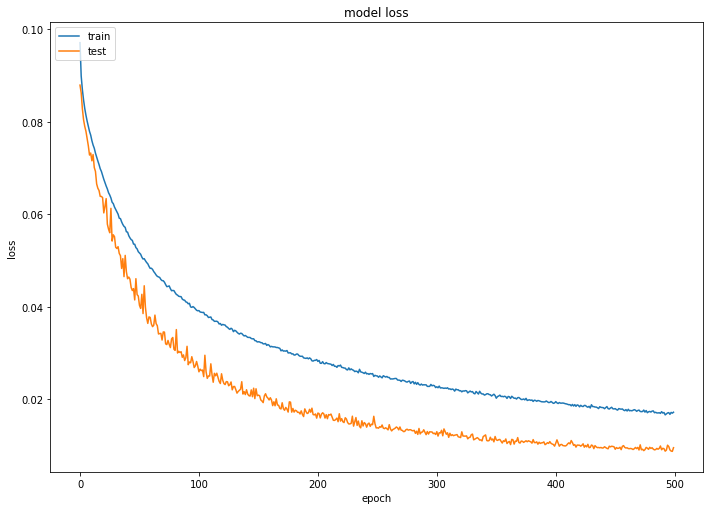

In [ ]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()